In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2 
import numpy as np
import os 
import time
import scipy.io as sc

### **BASE DE DATOS**

Se crea la base de datos con aproximadamente con 50 imágenes de cada emoción, las emociones se dividen en seis tipos diferentes tristeza, alegría, asco, neutral, sorpresa y enfado.

In [ ]:
cd /content/gdrive/MyDrive/Señales 3/Dataset_Emotion/

/content/gdrive/MyDrive/Señales 3/Dataset_Emotion


In [ ]:
#data = sc.loadmat('/content/gdrive/MyDrive/Señales3/Dataset_Emotion/')
path = ('/content/gdrive/MyDrive/Señales 3/Dataset_Emotion')
lista = os.listdir(path) #convierte el contenido del pat en una lista 
print(path,lista)

labelsINI = []
dataINI = []
labelINI = 0

for directorio in lista:
    emocionpath = path +'/'+ directorio # accedemos a la carpeta de cada emocion
    for imagen in os.listdir(emocionpath):
        dataINI.append(cv2.imread(emocionpath +'/'+imagen,0)) # agregar imagenes
        labelsINI.append(labelINI) # agregar etiquetas 
    
    labelINI= labelINI+1

/content/gdrive/MyDrive/Señales 3/Dataset_Emotion ['enfado', 'sorpresa', 'neutral', 'feliz', 'asco', 'triste']


##**Extraccion de crateristicas**

Se procede a la extracción de las características de la base de datos, específicamente de cada emoción, estas características se extraen mediante el algoritmo EiganFaces las cuales se guardar en un archivo de Excel para poder seguir con los demás procedimientos.

In [ ]:
## EigenFaces ##
labels =np.asarray(labelsINI)
EigenFaces_recognizer = cv2.face.EigenFaceRecognizer_create() # creamos el objeto LBPH
EigenFaces_recognizer.train(dataINI, labels) # entrenamos el algoritmo con las imagenes del dataset
vect = EigenFaces_recognizer.getEigenVectors()

vect = np.asarray(vect)
vect = vect.reshape(331,122500)
np.savetxt('caracteristicas_EF.csv',vect,delimiter=',',fmt="%f")
np.savetxt('labels.csv',labels,delimiter=' ',fmt='%s')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot as plt

## **SELECCIÓN DE CARACTERÍSTICAS**

Se procederá a evaluar varios tipos de algoritmos para la selección de características y así trabajar con el algoritmo que genere un mejor resultado.

In [ ]:
# cargar los datos
data = pd.read_csv("caracteristicas_EF.csv").to_numpy() #aqui cambia de 331 a 330
labels = pd.read_csv("labels.csv").to_numpy()
labels = labels.reshape(330)

data_norm = (data - np.mean(data))/np.std(data) #normalizamos los datos 
lw=2
target_names = ['enfado', 'sorpresa', 'neutral', 'feliz', 'asco', 'triste']
colors =['orange','green','blue','red','black','pink']

<Figure size 432x288 with 0 Axes>

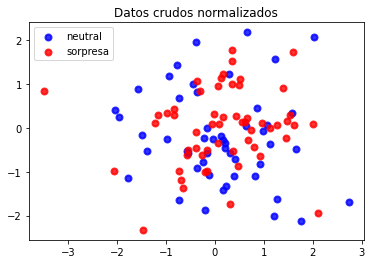

<Figure size 432x288 with 0 Axes>

In [ ]:
# Datos crudos
target_names = ['neutral','sorpresa']
colors=['blue','red']
for color, i, target_name in zip(colors, [3,4], target_names):
    plt.scatter(data_norm[labels == i, 0], data_norm[labels == i, 1], color=color, alpha=.8,lw=lw,label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Datos crudos normalizados')
plt.figure()

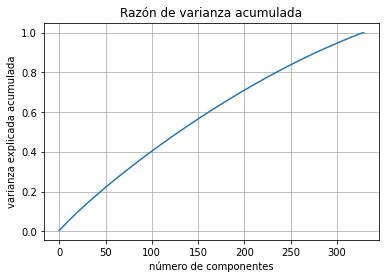

In [ ]:
# PCA Razón de varianza acumulada 

pca = PCA().fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Razón de varianza acumulada')
plt.xlabel('número de componentes')
plt.ylabel('varianza explicada acumulada');
plt.grid()

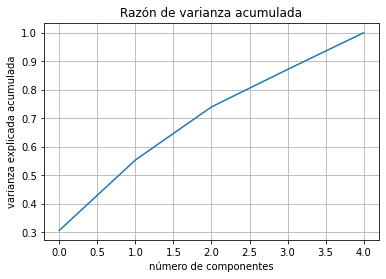

In [ ]:
# LDA Razón de varianza acumulada
lda = LinearDiscriminantAnalysis().fit(data,labels)
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.title('Razón de varianza acumulada')
plt.xlabel('número de componentes')
plt.ylabel('varianza explicada acumulada');
plt.grid()

In [ ]:
# PCA (análisis de componentes principales)

pcaObj = PCA(n_components=5)
pca = pcaObj.fit_transform(data)

#dataframe = pd.DataFrame(data)
#dataframe["labels"] = labels
#sb.pairplot(dataframe,hue = "labels")

np.savetxt('caracteristicas-Pca.csv',pca,delimiter=',',fmt="%f")

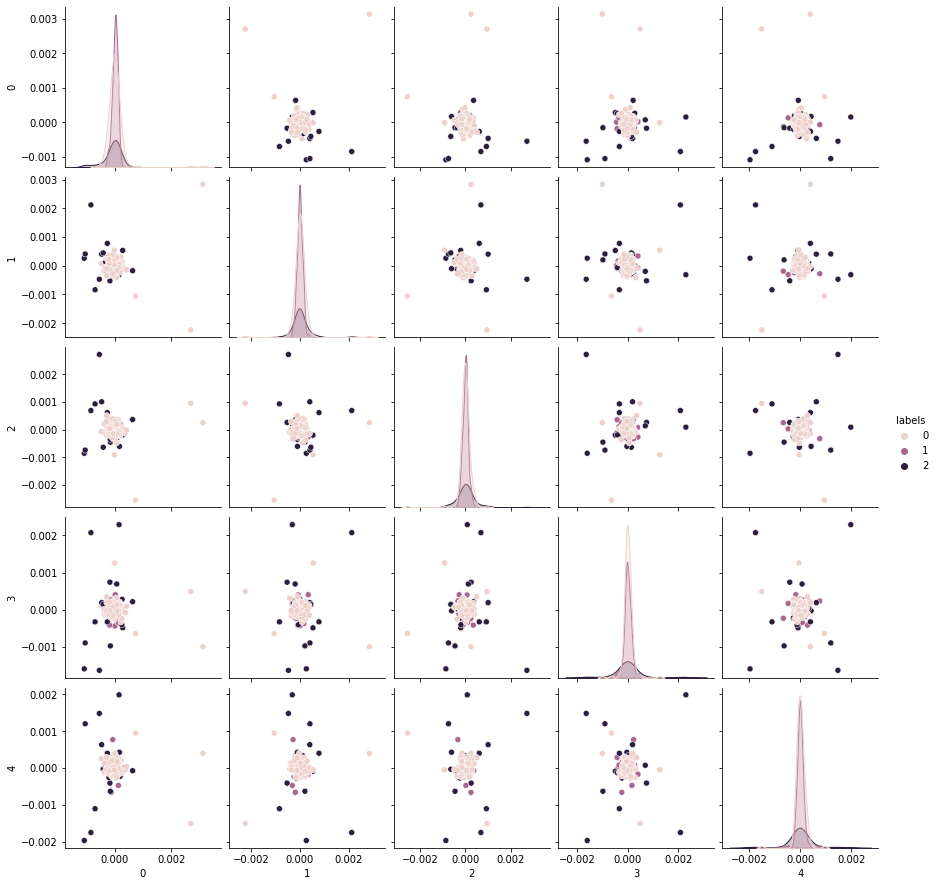

In [ ]:
# kernel_PCA (análisis de componentes principales)

kpcaObj = KernelPCA(n_components = 5, kernel = 'rbf',fit_inverse_transform=True)
kpca = kpcaObj.fit_transform(data)
labels = pd.read_csv("labels.csv").to_numpy()
labels = labels.reshape(330)
labelsAux = labels

vectt=labels
for i in range(0, 58):
  vectt[i]=0   #Negativas
for i in range(58, 124):
  vectt[i]=1   #Positivas
for i in range(124, 176):
  vectt[i]=2    #Neutral
for i in range(176, 226):
  vectt[i]=1    #Positivas
for i in range(226, 282):
  vectt[i]=0    #Negativas
for i in range(282, 330):
  vectt[i]=0    #Negativas

dataframe = pd.DataFrame(kpca)
dataframe["labels"] = vectt
sb.pairplot(dataframe,hue = "labels")

np.savetxt('caracteristicas-KernelPca.csv',kpca,delimiter=',',fmt="%f")

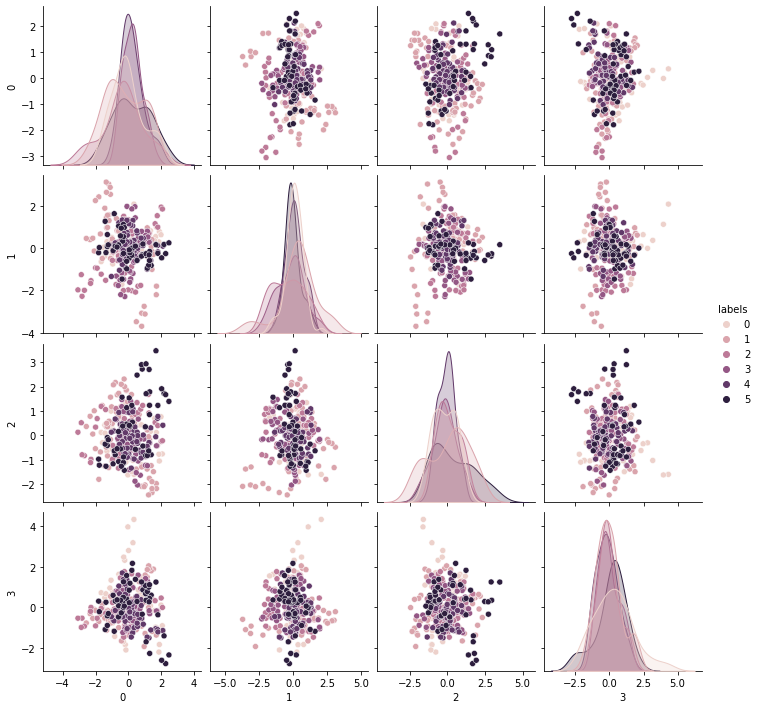

In [ ]:
# LDA (análisis de componentes principales)

labels = pd.read_csv("labels.csv").to_numpy()
labels = labels.reshape(330)

ldaObj = LinearDiscriminantAnalysis(n_components=4)
lda = ldaObj.fit(data_norm,labels).transform(data_norm)

dataframe = pd.DataFrame(lda)
dataframe["labels"] = labels
sb.pairplot(dataframe, hue = "labels")

np.savetxt('caracteristicas-Lda.csv',lda,delimiter=',',fmt="%f")

Al utilizar diversos métodos de analisic de componentes principales, pudimos apreciar de manera clara que se obtuvo una mejor clasificación al hacer uso de la función KernelPCA, con un valor de 5 componentes y con un kernel de tipo rbf. Al utilizar esta función con los valores mencionados podemos observar que se obtiene una distinción clara en el espacio subyacente, entre caras que representan las distintas emociones.

##**ENTRENAMIENTO Y VALIDACIÓN**


In [ ]:
# importar librerias

from sklearn.model_selection import ShuffleSplit # validador cruzado de permutación aleatoria 
from sklearn.preprocessing import StandardScaler # normalizar datos
from sklearn.svm import SVC # clasificador SVM
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay # rendimiento para evaluar los splits 
from sklearn.model_selection import train_test_split 


# **ENTRENAMIENTO MEDIANTE LOS DATOS OBTENIDOS CON LDA**

In [ ]:
# Cargar datos de características LDA

#data = pd.read_csv("caracteristicas-KernelPca.csv").to_numpy() # cargamos caracteristicas lda
#labels = pd.read_csv("labels.csv").to_numpy() # cargamos etiquetas 
#labels = labels.reshape(330)

data = pd.read_csv("caracteristicas-Lda.csv").to_numpy() # cargamos caracteristicas lda
labels = pd.read_csv("labels.csv").to_numpy() # cargamos etiquetas 
labels = labels.reshape(330)

# 2. Generación splits (solo una vez)

test_percent=30 
ss=ShuffleSplit(n_splits=5, test_size=test_percent/100.0)
split = 1
for train_index,test_index in ss.split(data): # train index indica los indices de entrenamiento, test index los de prueba
    X_train=data[train_index,:] # Obtener los datos de entrenamiento
    y_train=labels[train_index]
    zParam=StandardScaler().fit(X_train) # Obtener los parametros de estandarizacion
    X_train=zParam.transform(X_train) # Estandarizar los datos de entrenamiento
    X_test=zParam.transform(data[test_index,:]) # Obtener y estandarizar los datos de prueba
    y_true=labels[test_index]
    if split==1:
        np.savetxt('train1.txt',X_train,fmt='%5.15f')
        np.savetxt('labelsTrain1.txt',y_train,fmt='%5.15f')
        np.savetxt('test1.txt',X_test,fmt='%5.15f')
        np.savetxt('labelsTest1.txt',y_true,fmt='%5.15f')
        
    if split==2:
        np.savetxt('train2.txt',X_train,fmt='%5.15f')
        np.savetxt('labelsTrain2.txt',y_train,fmt='%5.15f')
        np.savetxt('test2.txt',X_test,fmt='%5.15f')
        np.savetxt('labelsTest2.txt',y_true,fmt='%5.15f')

    if split==3:
        np.savetxt('train3.txt',X_train,fmt='%5.15f')
        np.savetxt('labelsTrain3.txt',y_train,fmt='%5.15f')
        np.savetxt('test3.txt',X_test,fmt='%5.15f')
        np.savetxt('labelsTest3.txt',y_true,fmt='%5.15f')

    if split==4:
        np.savetxt('train4.txt',X_train,fmt='%5.15f')
        np.savetxt('labelsTrain4.txt',y_train,fmt='%5.15f')
        np.savetxt('test4.txt',X_test,fmt='%5.15f')
        np.savetxt('labelsTest4.txt',y_true,fmt='%5.15f')
        
    if split==5:
        np.savetxt('train5.txt',X_train,fmt='%5.15f')
        np.savetxt('labelsTrain5.txt',y_train,fmt='%5.15f')
        np.savetxt('test5.txt',X_test,fmt='%5.15f')
        np.savetxt('labelsTest5.txt',y_true,fmt='%5.15f')
        
    split = split+1
    

In [ ]:
# 3. Cargamos splits (siempre)

train1 = np.loadtxt('train1.txt')
train2 = np.loadtxt('train2.txt')
train3 = np.loadtxt('train3.txt')
train4 = np.loadtxt('train4.txt')
train5 = np.loadtxt('train5.txt')
trains = [train1,train2,train3,train4,train5]

test1 = np.loadtxt('test1.txt')
test2 = np.loadtxt('test2.txt')
test3 = np.loadtxt('test3.txt')
test4 = np.loadtxt('test4.txt')
test5 = np.loadtxt('test5.txt')
tests = [test1,test2,test3,test4,test5]

labelsTrain1 = np.loadtxt('labelsTrain1.txt')
labelsTrain2 = np.loadtxt('labelsTrain2.txt')
labelsTrain3 = np.loadtxt('labelsTrain3.txt')
labelsTrain4 = np.loadtxt('labelsTrain4.txt')
labelsTrain5 = np.loadtxt('labelsTrain5.txt')
labelsTrains =[labelsTrain1,labelsTrain2,labelsTrain3,labelsTrain4,labelsTrain5]

labelsTest1 = np.loadtxt('labelsTest1.txt')
labelsTest2 = np.loadtxt('labelsTest2.txt')
labelsTest3 = np.loadtxt('labelsTest3.txt')
labelsTest4 = np.loadtxt('labelsTest4.txt')
labelsTest5 = np.loadtxt('labelsTest5.txt')
labelsTests =[labelsTest1,labelsTest2,labelsTest3,labelsTest4,labelsTest5]

In [ ]:
# sistema de clasificacion y validación 

Accuracy=[]
gama=[0.01,0.05,0.1,0.5,1]
kernel='rbf' # 'linear' , 'sigmoid'
C=1

for g in gama:
    svm =SVC(kernel=kernel,C=C,gamma=g)
    
    for train,labelsTrain,test,labelsTest in zip(trains, labelsTrains, tests, labelsTests):
        svm.fit(train,labelsTrain)
        labels_pred = svm.predict(test)
        accuracy = accuracy_score(labelsTest,labels_pred)
        Accuracy.append(accuracy*100)

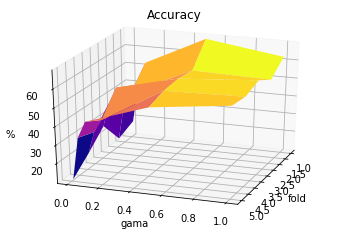

In [ ]:
# Gráfica 3d para encontrar parametro gama

z = np.asarray(Accuracy)
z = np.reshape(z,(5,5))
#z = z.T
x = [1,2,3,4,5]
y= [0.01,0.05,0.1,0.5,1]
fig = plt.figure()
ax3d = plt.axes(projection="3d")
X,Y = np.meshgrid(x,y)
ax3d.plot_surface(X, Y, z,cmap='plasma',linewidth=0, )
ax3d.view_init(25, 20)  #25,20
ax3d.set_title('Accuracy')
ax3d.set_xlabel('fold')
ax3d.set_ylabel('gama')
ax3d.set_zlabel('%')
plt.show()

Acuracy:  63.63636363636363
std:  0.0


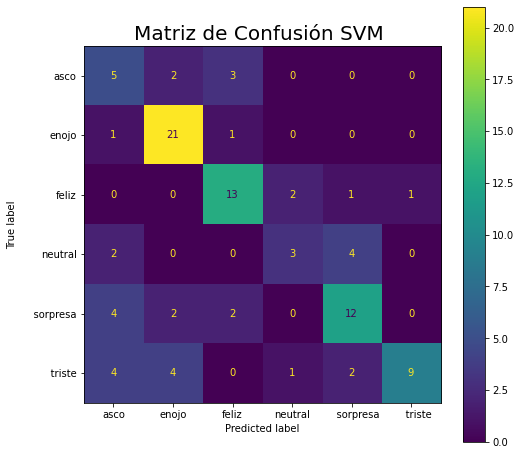

In [ ]:
# Entrenar y guardar sistema entrenado con datos lda
# from joblib import dump, load

Accuracy=[]
gama = 0.6
kernel = 'rbf'
C=100  # parametro de regulacion
svm =SVC(kernel=kernel,C=C,gamma=g)

#for train,labelsTrain,test,labelsTest in zip(trains, labelsTrains, tests, labelsTests):
svm.fit(train,labelsTrain)
labels_pred = svm.predict(test)
accuracy = accuracy_score(labelsTest,labels_pred)
Accuracy.append(accuracy*100)

print("Acuracy: ", np.mean(Accuracy))
print("std: ", np.std(Accuracy))

cm = confusion_matrix(labelsTest5,labels_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['asco','enojo','feliz','neutral','    sorpresa','     triste'])

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Matriz de Confusión SVM ",fontsize=20)
cmp.plot(ax =ax)

# **ENTRENAMIENTO MEDIANTE LOS DATOS OBTENIDOS CON PCA**

In [ ]:
# Cargar datos de características PCA

data = pd.read_csv("caracteristicas-Pca.csv").to_numpy() # cargamos caracteristicas lda
labels2 = pd.read_csv("labels.csv").to_numpy() # cargamos etiquetas 
labels2 = labels2.reshape(330)
labels2 = np.delete(labels2,329,0)

# Dividimos el conjunto de datos en Entrenamiento y Test
train, test, labelsTrain, labelsTest = train_test_split(data, labels2, random_state = 35)

Acc test:  [22.89156626506024]


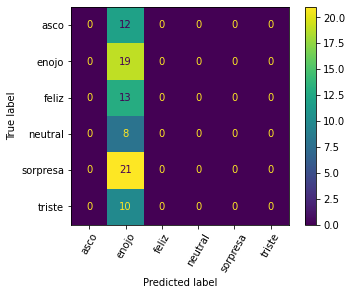

In [ ]:
#%% sistema de clasificacion y validación PCA

Accuracy=[]
gama=[0.01,0.05,0.1,0.5,1]
kernel='rbf' # 'linear' , 'sigmoid'
C=1
svm =SVC(kernel=kernel,C=C,gamma=0.01)
svm.fit(train,labelsTrain)
labels_pred = svm.predict(test)
accuracy = accuracy_score(labelsTest,labels_pred)
Accuracy.append(accuracy*100)
cMat_test = confusion_matrix(labelsTest, labels_pred)

print('Acc test: ',Accuracy)
ax1 = ConfusionMatrixDisplay(cMat_test, display_labels=['asco', 'enojo', 'feliz', 'neutral', 'sorpresa', 'triste'])
ax1.plot(xticks_rotation = 60)
plt.show()

In [ ]:

idx = int(len(labelsTest)*np.random.rand(1))
imageRec = PCA.inverse_transform(test[idx])
#inverse_transform(test[idx])
imageRec =imageRec.reshape((62, 47))
plt.imshow(imageRec,cmap='gray')
plt.axis('off')
titulo = 'Predicción ({})\n Etiqueta ({})'.format(labels[labels_pred[idx]],labels[labelsTest[idx]])
if labels_pred[idx] == labelsTest[idx]:
  plt.title(titulo, color = 'green')
else:
  plt.title(titulo, color = 'red')
plt.show()

TypeError: ignored

# Nueva sección